In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Data used for betting has been precomputed. Teams and dates are given for reference but are not relevant to the calculation. Week is provided for the ability to compare performance by week in the season as the scoring algorithm performs better later in the season. All playoff games are given a week value of 19. The scores in the score column are calculated by an algorithm. A positive value represents the home team is predicted to be more likely to win, and a negative value represents the away team is predicted to be more likely to win. The higher the absolute value, the higher the probability of that team winning.

In [2]:
train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')
val_df = pd.read_csv('val_data.csv')

train_df.head()

,home_team,away_team,date,week,score,home_b,away_b,target
0,gnb,chi,2011-01-02,17,0.317287,0.181818,4.000000,1
1,gnb,cle,2013-10-20,7,0.818623,0.222222,3.300000,1
2,atl,nor,2020-12-06,13,-0.505128,1.190000,0.694444,0
3,sea,nwe,2020-09-20,2,0.175597,0.465116,1.750000,1
4,was,nyg,2020-11-08,9,0.055124,0.694444,1.190000,0


#### For this strategy picture a square matrix where the top left is the 0th percentile of scores and home bet payouts and the bottom right is the 100th percentile. Values in this matrix represent the percent of the bankroll to be bet. Positive values denote the value to bet on the home team, and negative values denote the value to bet on the away team. The figure below is a visual representation of this system. Personal risk management allows a maximum of 25% of the bankroll to be bet on games - any values for the maximum and minimum could be chosen. This could also be asymetric where more can be bet on one side. On average, the home team wins about 56% of the time, so it may make more sense to have a higher maximum bet for the home team than the away team. Testing will be done to find the optimal bet sizes up to 25% of the bankroll for the maximum bet.

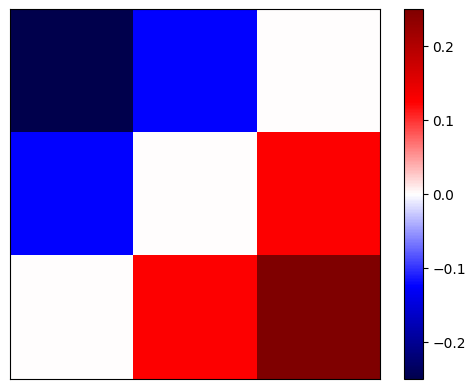

In [18]:
arr = [
    [-0.25, -0.125, 0],
    [-0.125, 0, 0.125],
    [0, 0.125, 0.25]
]

plt.figure()
plt.imshow(arr, cmap='seismic')
plt.colorbar()
plt.yticks([])
plt.xticks([])
plt.show();

#### The implementation of the above system is done on the training data. Maximum and minimum bet sizes are set. The mid point is found. The step size is computed - the step size can be thought of as stepping through the matrix. The fraction of the bankroll to bet is the minimum bet + the step size *  the score percentile + the step size * home payout percentile. This is equivalent to the above matrix.

In [3]:
# Precompute the necessary percentages for each game
train_df['score_pct'] = train_df.score.rank(pct=True)
train_df['b_pct'] = train_df.home_b.rank(pct=True)

starting_bal = 100

# Test each combination of minimum and maximum bets in 1% increments
for a in np.arange(0, 0.26, 0.01):
    best_bal = -np.inf
    best_b = np.nan
    for b in np.arange(0, 0.26, 0.01):
        bal = starting_bal

        # max_bet would be home, and min_bet would be away
        max_bet = a
        min_bet = -b

        mid = (max_bet + min_bet) / 2

        step = (max_bet - mid)

        for _, game in train_df.iterrows():
            # Use precomputed values
            score_pct = game['score_pct']
            b_pct = game['b_pct']

            # Calculate betting fraction and bet size
            bet_frac = min_bet + step * (score_pct + b_pct)
            # round to nearest $5
            bet = round(abs(bet_frac * bal / 5)) * 5

            # Update balance based on the result of the bet
            if bet_frac > 0 and game.target == 1:
                bal += bet * game.home_b
            elif bet_frac < 0 and game.target == 0:
                bal += bet * game.away_b
            else:
                bal -= bet

        if bal > best_bal:
            best_bal = bal
            best_b = b
    
    # Geometric mean is shown to account for compounding
    print(a, best_b, round((best_bal / starting_bal) ** (1 / len(train_df)), 3))


0.0 0.04 1.0
0.01 0.04 1.001
0.02 0.05 1.001
0.03 0.04 1.002
0.04 0.05 1.003
0.05 0.06 1.003
0.06 0.07 1.004
0.07 0.09 1.004
0.08 0.1 1.005
0.09 0.11 1.006
0.1 0.11 1.006
0.11 0.12 1.007
0.12 0.13 1.007
0.13 0.14 1.008
0.14 0.15 1.008
0.15 0.18 1.009
0.16 0.18 1.009
0.17 0.19 1.01
0.18 0.2 1.01
0.19 0.21 1.01
0.2 0.22 1.011
0.21 0.24 1.011
0.22 0.23 1.012
0.23 0.24 1.012
0.24 0.25 1.013
0.25 0.25 1.013


#### As can be seen from the above testing, there is an increasing trend where a larger maximum and minimum bet size allow for more profit. The minimum bet size should be roughly the same in absolute value as the maximum bet. The next step will be to test on the testing and validation data sets.

In [20]:
count = len(train_df)
bal = 100
starting_bal = bal

max_bet = .25
min_bet = -.25

mid = (max_bet + min_bet) / 2

step = (max_bet - mid)

for _, game in test_df.iterrows():
    score_pct = (game.score > train_df.score).sum() / count
    b_pct = (game.home_b > train_df.home_b).sum() / count
    
    bet_frac = min_bet + step * (score_pct + b_pct)
    # round to nearest $5
    bet = round(abs(bet_frac * bal / 5)) * 5

    if bal <= 0:
        print('Broke')
        break

    if bet_frac > 0 and game.target == 1:
        bal += bet * game.home_b
    elif bet_frac < 0 and game.target == 0:
        bal += bet * game.away_b
    else:
        bal -= bet
profit = (bal / starting_bal) ** (1 / len(test_df)) - 1
print(f'{round(100 * profit, 2)}% profit per game')

1.89% profit per game


In [24]:
count = len(train_df)
bal = 100
starting_bal = bal

max_bet = .25
min_bet = -.25

mid = (max_bet + min_bet) / 2

step = (max_bet - mid)

max_actual_bet = 0

for _, game in val_df.iterrows():
    score_pct = (game.score > train_df.score).sum() / count
    b_pct = (game.home_b > train_df.home_b).sum() / count
    
    bet_frac = min_bet + step * (score_pct + b_pct)
    # round bet to nearest $5
    bet = round(abs(bet_frac * bal / 5)) * 5

    if abs(bet_frac) > max_actual_bet:
        max_actual_bet = abs(bet_frac)

    if bal <= 0:
        print('Broke')
        break

    if bet_frac > 0 and game.target == 1:
        bal += bet * game.home_b
    elif bet_frac < 0 and game.target == 0:
        bal += bet * game.away_b
    else:
        bal -= bet

profit = (bal /starting_bal) ** (1 / len(val_df)) - 1
print(f'{round(100 * profit, 2)}% profit per game')
print(f'Final balance: ${round(bal, 2)}')

1.22% profit per game
Final balance: $2556.51


#### Across all data sets around 1.2% - 1.9% profit is made on average per game. Since this is calculated using the geometric mean, the value is cumulative. Using this system in 2023 would have resulted in a starting bankroll of $100 turning into $2556.51 assuming games were consecutive. Of course, games are not consecutive, so testing for optimization for concurrent games will need to be done; however, this serves as a starting point. Additionally, because training, testing, and validation are all similar in returns, overfitting should not be expected, so this model will be used during the 2024 season to see if similar returns can be made. During development of the scoring algorithm care was taken to avoid overfitting as well.